In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import geopandas as gpd
from geopy.distance import great_circle
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors

In [6]:
deegan_02aug = "F:/Maxar data/geotiffs/02AUG05153314-S3AS-016353375010_01_P001.tif"
deegan_06jul = "F:/Maxar data/geotiffs/06JUL16154628-S2AS-016353376010_01_P001.tif"
deegan_06aug = "F:/Maxar data/geotiffs/06AUG31155830-S3AS-016353373010_01_P001.tif"
deegan_09aug = "F:/Maxar data/geotiffs/09AUG27155740-S3DS-016353374010_01_P001.tif"
deegan_10nov = "F:/Maxar data/geotiffs/10NOV18154439-M3DS-016352249010_01_P001.tif"
deegan_12aug_a = "F:/Maxar data/geotiffs/12AUG17155429-M3DS-016352245010_01_P001.tif"
deegan_12aug_b = "F:/Maxar data/geotiffs/12AUG17155442-M3DS-016352247010_01_P001.tif"
deegan_22jun = "F:/Maxar data/geotiffs/22JUN21152822-M3DS-016352251010_01_P001.tif"
deegan_22oct = "F:/Maxar data/geotiffs/22OCT12153154-M3DS-016352248010_01_P001.tif"
deegan_24jun_a = "F:/Maxar data/geotiffs/24JUN11154200-M3DS-016352250010_01_P001.tif"
deegan_24jun_b = "F:/Maxar data/geotiffs/24JUN13154133-M3DS-016352246010_01_P001.tif"


deegan_paths = [deegan_02aug, deegan_06jul, deegan_06aug, deegan_09aug, deegan_10nov, deegan_12aug_a, deegan_12aug_b, \
               deegan_22jun, deegan_22oct, deegan_24jun_a]

deegan_single = [deegan_02aug]

In [20]:
# Function to check and print the CRS of each image
def check_crs(image_paths):
    for path in image_paths:
        with rasterio.open(path) as src:
            print(f"File: {path}")
            print(f"CRS: {src.crs}\n")

# Check the CRS of each image
# check_crs(deegan_paths)

In [41]:
#Bounding box for specific Deegan creek
xmin = 42.721053
xmax = 42.722478
ymin = -70.847954
ymax = -70.845806

In [17]:
# import rioxarray
from rasterio.warp import calculate_default_transform, reproject, Resampling

x_reprojected = "F:/Maxar data/geotiffs/22OCT12153154-REPROJECTED.tif"

crs = 4326

def reproject_raster(in_path, out_path):

    """
    """
    # reproject raster to project crs
    with rasterio.open(in_path) as src:
        src_crs = src.crs
        transform, width, height = calculate_default_transform(src_crs, crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()

        kwargs.update({
            'crs': crs,
            'transform': transform,
            'width': width,
            'height': height})

        with rasterio.open(out_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=crs,
                    resampling=Resampling.nearest)
    return(out_path)

# reproject_raster(deegan_22oct, x_reprojected)

'F:/Maxar data/geotiffs/22OCT12153154-REPROJECTED.tif'

In [18]:
x1='F:/Maxar data/geotiffs/24JUN11154200-REPROJECTED.tif'
x2='F:/Maxar data/geotiffs/06JUL16154628-REPROJECTED.tif'
x3='F:/Maxar data/geotiffs/10NOV18154439-REPROJECTED.tif'
x4='F:/Maxar data/geotiffs/12AUG17155429-REPROJECTED.tif'
x5='F:/Maxar data/geotiffs/12AUG17155442-REPROJECTED.tif'
x6='F:/Maxar data/geotiffs/22JUN21152822-REPROJECTED.tif'
x7='F:/Maxar data/geotiffs/22OCT12153154-REPROJECTED.tif'

# check_crs(x2)

reprojected_paths = [deegan_02aug, x2, deegan_06aug, deegan_09aug, x3, x4, x5, x6, x7, x1] #be very careful with the order here

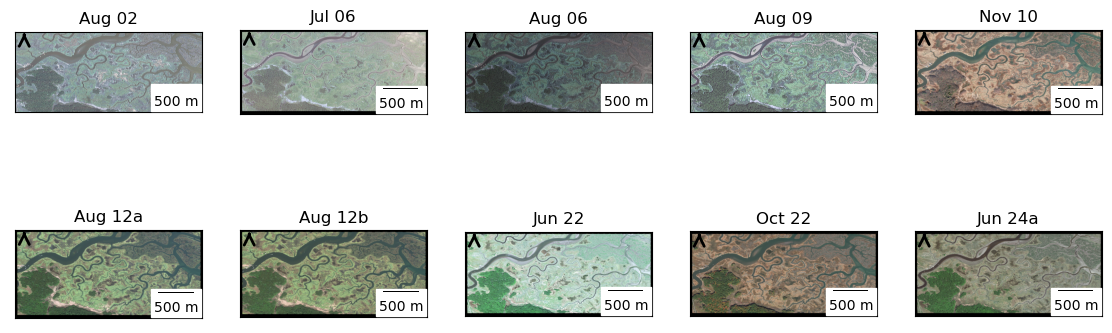

In [44]:
from rasterio.windows import from_bounds

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title, band_indices):
    with rasterio.open(geotiff_path) as src:
        red = src.read(band_indices[0])
        green = src.read(band_indices[1])
        blue = src.read(band_indices[2])
        
        # Stack the bands to form an RGB image
        rgb = np.dstack((red, green, blue))        
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
        im = ax.imshow(rgb, extent=extent)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)
        
        ax.annotate('', xy=(0.05, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.05, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='black'))
        
        ax.set_title(title)
        
        return im
    
# Calculate dx for scale_bar
point1 = (31.425, -81.29)
point2 = (31.425, -80.29)
dx = great_circle(point1, point2).meters

fig, axs = plt.subplots(2, 5, figsize=(15, 5))  # Adjusted figsize

ims = []
titles = ['Aug 02', 'Jul 06', 'Aug 06', 'Aug 09', 'Nov 10', 'Aug 12a', 'Aug 12b', 'Jun 22', 'Oct 22', 'Jun 24a', 'Jun 24b']
data_min = float('inf')
data_max = float('-inf')

# for i, ax in enumerate(axs.flat):
#     with rasterio.open(reprojected_paths[i]) as src: #deegan_paths for original tiff files - they have different projections tho
#         red = src.read(1)
#         green = src.read(2)
#         blue = src.read(3)

band_combinations = [
    (3, 2, 1),
    (3, 2, 1),
    (3, 2, 1),
    (3, 2, 1),
    (5, 3, 2),
    (4, 3, 2),
    (4, 3, 2),
    (4, 3, 2),
    (5, 3, 2),
    (5, 3, 2),
]

for i, ax in enumerate(axs.flat):
    im = plot_geotiff_with_scale_and_north_arrow(reprojected_paths[i], ax, titles[i], band_combinations[i])
    ims.append(im)

plt.suptitle('', fontsize=16)

fig.subplots_adjust(right=0.85)
plt.subplots_adjust(top=0.85)

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('allsap_trend.png',bbox_inches='tight', dpi = 300)

plt.show()


ValueError: zero-size array to reduction operation maximum which has no identity

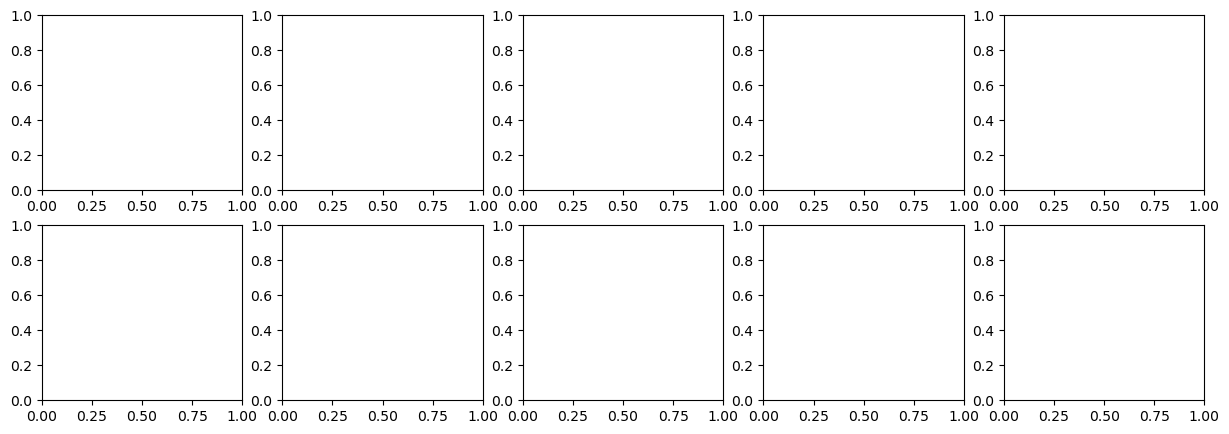

In [42]:
from rasterio.windows import from_bounds

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title, band_indices, bbox = None):
    with rasterio.open(geotiff_path) as src:
        if bbox:
            window = from_bounds(bbox[0], bbox[1], bbox[2], bbox[3], src.transform)
        else:
            window = None
            
        red = src.read(band_indices[0], window = window)
        green = src.read(band_indices[1], window = window)
        blue = src.read(band_indices[2], window = window)
        
        # Stack the bands to form an RGB image
        rgb = np.dstack((red, green, blue))        
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top) if not window else (
            bbox[0], bbox[2], bbox[1], bbox[3])
        
        if np.max(rgb) == 0:
            print(f"No valid data found within the bounding box {bbox} for raster {geotiff_path}")
            return
        
        rgb_normalized = rgb / np.max(rgb) 
        
        im = ax.imshow(rgb, extent=extent)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)
        
        ax.annotate('', xy=(0.05, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.05, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='black'))
        
        ax.set_title(title)
        
        return im
    
# Calculate dx for scale_bar
point1 = (31.425, -81.29)
point2 = (31.425, -80.29)
dx = great_circle(point1, point2).meters

bbox = (xmin, ymin, xmax, ymax)

fig, axs = plt.subplots(2, 5, figsize=(15, 5))  # Adjusted figsize

ims = []
titles = ['Aug 02', 'Jul 06', 'Aug 06', 'Aug 09', 'Nov 10', 'Aug 12a', 'Aug 12b', 'Jun 22', 'Oct 22', 'Jun 24a', 'Jun 24b']
data_min = float('inf')
data_max = float('-inf')

# for i, ax in enumerate(axs.flat):
#     with rasterio.open(reprojected_paths[i]) as src: #deegan_paths for original tiff files - they have different projections tho
#         red = src.read(1)
#         green = src.read(2)
#         blue = src.read(3)

band_combinations = [
    (3, 2, 1),
    (3, 2, 1),
    (3, 2, 1),
    (3, 2, 1),
    (5, 4, 3),
    (4, 3, 2),
    (4, 3, 2),
    (4, 3, 2),
    (5, 4, 3),
    (5, 4, 3),
]

for i, ax in enumerate(axs.flat):
    im = plot_geotiff_with_scale_and_north_arrow(reprojected_paths[i], ax, titles[i], band_combinations[i], bbox)
    ims.append(im)

plt.suptitle('', fontsize=16)

fig.subplots_adjust(right=0.85)
plt.subplots_adjust(top=0.85)

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('allsap_trend.png',bbox_inches='tight', dpi = 300)

plt.show()


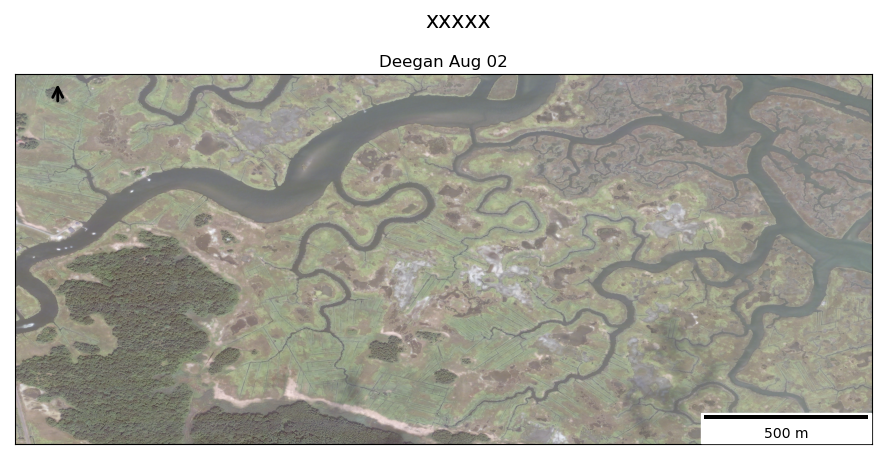

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from geopy.distance import great_circle
from matplotlib_scalebar.scalebar import ScaleBar

deegan_02 = "F:/Maxar data/geotiffs/02AUG05153314-S3AS-016353375010_01_P001.tif"

def plot_geotiff_with_scale_and_north_arrow(geotiff_path, ax, title, data_min, data_max):
    with rasterio.open(geotiff_path) as src:
        # Read the first three bands (assuming they are R, G, B respectively)
        red = src.read(1)
        green = src.read(2)
        blue = src.read(3)
        
        # Stack the bands to form an RGB image
        rgb = np.dstack((red, green, blue))
        
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)
        
        # Normalize the RGB values to range between 0 and 1 for display
#         rgb_normalized = rgb / np.max(rgb)
        rgb_normalized = rgb
        
        im = ax.imshow(rgb_normalized, extent=extent)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)
        
        ax.annotate('', xy=(0.05, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.05, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='black'))
        
        ax.set_title(title)
        
        return im
    
# Calculate dx for scale_bar
point1 = (31.425, -81.29)
point2 = (31.425, -80.29)
dx = great_circle(point1, point2).meters

fig, ax = plt.subplots(1, 1, figsize=(12, 5))  # Adjusted figsize

titles = ['Deegan Aug 02']

# Read the image and get the min and max values for normalization
with rasterio.open(deegan_02) as src:
    red = src.read(1)
    green = src.read(2)
    blue = src.read(3)
    data_min = min(np.min(red), np.min(green), np.min(blue))
    data_max = max(np.max(red), np.max(green), np.max(blue))

# Plot the image
im = plot_geotiff_with_scale_and_north_arrow(deegan_02, ax, titles[0], data_min, data_max)

plt.suptitle('xxxxx', fontsize=16)

fig.subplots_adjust(right=0.85)
plt.subplots_adjust(top=0.85)

# cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
# Note: Colorbars for RGB images are not very meaningful, so this can be omitted or adjusted
# cbar = plt.colorbar(im, cax=cbar_ax, label='xxxx')

# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('allsap_trend.png', bbox_inches
